# Real Fake Dataset Creation
In this notebook we create the Real-Fake Dataset.
Using the Real-Fake forms dataset, we created an algorithm to read each of these forms, segment crop and classify each word using the Microsoft API and save it into the correct folder.

The Dataset consists of 6 folders:
(1) Real Train
(2) Fake Train

(3) Real Validation
(4) Fake Validation

(5) Real Test
(6) Fake Test

# **Imports**

In [ ]:
import time 
import json
import base64
import matplotlib.pyplot as plt
import requests
import numpy as np
import cv2
from PIL import Image
from io import BytesIO
from matplotlib.lines import Line2D
from tqdm import tqdm
from google.colab import drive
from glob import glob
import os
import uuid
from pylab import rcParams
rcParams['figure.figsize'] = 10, 15
%matplotlib inline 

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Variables

endpoint = 'https://eylon.cognitiveservices.azure.com' # Endpoint from the Azure portal
subscription_key = '81003b7a3705483988987e2b2977329d' # One of the two keys coresponding with the above endpoint
text_recognition_url = endpoint + "/vision/v3.0/read/analyze" # Full analyzer path for the API request

# **Helper functions**

In [ ]:
def getOCRTextResult( operationLocation, headers ):
    """
    Helper function to get text result from operation location

    Parameters:
    operationLocation: operationLocation to get text result, See API Documentation
    headers: Used to pass the key information
    """

    retries = 0
    result = None

    while True:
        response = requests.request('get', operationLocation, json=None, data=None, headers=headers, params=None)
        if response.status_code == 429:
            print("Message: %s" % (response.json()))
            time.sleep(10)
        elif response.status_code == 200:
            result = response.json()
        else:
            print("Error code: %d" % (response.status_code))
            print("Message: %s" % (response.json()))
        break

    return result

In [ ]:
def showResultsOnImage(result, img):
    """Display the obtained results onto the input image"""

    fig, ax = plt.subplots(figsize=(12, 12))
    if len(img.shape) == 3:
        img = img[:, :, (2, 1, 0)]
        ax.imshow(img, aspect='equal')
    elif len(img.shape) == 2:
        ax.imshow(img, aspect='equal', cmap='gray')
        
    word_images, labels = list(), list()

    lines = result['analyzeResult']['readResults'][0]['lines']
    line_bounds = list()

    for i in range(len(lines)):
        allHs, line_h1, line_h2, line_w1, line_w2 = 0, 99999999, -1, 99999999, -1
        words = lines[i]['words']
        for j in range(len(words)):
            # The API returns the four corners of the box in X,Y coordinates. So:
            # X top left, Y top left, X top right, Y top right, X bottom right, Y bottom right, X bottom left, Y bottom left


            tl = (words[j]['boundingBox'][0]-5, words[j]['boundingBox'][1])
            tr = (words[j]['boundingBox'][2]+5, words[j]['boundingBox'][3])
            br = (words[j]['boundingBox'][4]+5, words[j]['boundingBox'][5]+7)
            bl = (words[j]['boundingBox'][6]-5, words[j]['boundingBox'][7]+7)
            text = words[j]['text']
            x = [tl[0], tr[0], tr[0], br[0], br[0], bl[0], bl[0], tl[0]]
            y = [tl[1], tr[1], tr[1], br[1], br[1], bl[1], bl[1], tl[1]]
            h1, h2 = max(tl[1], tr[1]), min(bl[1], br[1])
            w1, w2 = max(tl[0], bl[0]), min(tr[0], br[0])

            line_h1 = min(line_h1,h1)
            line_h2 = max(line_h2,h2)
            line_w1 = min(line_w1,w1)
            line_w2 = max(line_w2,w2)
            word_img = img[h1:h2, w1:w2]

            if len(word_img) > 0:
                labels.append(text)
                word_images.append(cv2.resize(word_img, (216, 64)))

            line = Line2D(x, y, linewidth=3.5, color='red')
            ax.add_line(line)


        if (line_h1-line_h2)*(line_w1-line_w2) < 4000:
            continue
        line_bounds.append([line_h1, line_h2, line_w1, line_w2])
        allHs+=1+line_w2-line_w1

    meanH = allHs/len(lines)
    newLines=[]
    line_images = list()
    for bounds,line in zip(line_bounds, lines):
        trans = line['text']
        bounds = [round(v) for v in bounds]
        newLines.append((bounds,trans))
        line_images.append(img[bounds[0]:bounds[1], bounds[2]:bounds[3]])

    plt.axis('off')
    plt.tight_layout()
    plt.draw()
    plt.show()

    

    return word_images, line_images, labels 

In [ ]:
def getCroppedImagesAndLabels(result, img):
    """Display the obtained results onto the input image"""

    if len(img.shape) == 3:
        img = img[:, :, (2, 1, 0)]
        
    word_images, labels = list(), list()

    lines = result['analyzeResult']['readResults'][0]['lines']
    line_bounds = list()

    for i in range(len(lines)):
        words = lines[i]['words']
        for j in range(len(words)):
            # The API returns the four corners of the box in X,Y coordinates. So:
            # X top left, Y top left, X top right, Y top right, X bottom right, Y bottom right, X bottom left, Y bottom left

           
            tl = (words[j]['boundingBox'][0], words[j]['boundingBox'][1])
            tr = (words[j]['boundingBox'][2], words[j]['boundingBox'][3])
            br = (words[j]['boundingBox'][4], words[j]['boundingBox'][5])
            bl = (words[j]['boundingBox'][6], words[j]['boundingBox'][7])
            text = words[j]['text']
            x = [tl[0], tr[0], tr[0], br[0], br[0], bl[0], bl[0], tl[0]]
            y = [tl[1], tr[1], tr[1], br[1], br[1], bl[1], bl[1], tl[1]]
            h1, h2 = max(tl[1], tr[1]), min(bl[1], br[1])
            w1, w2 = max(tl[0], bl[0]), min(tr[0], br[0])

            if img is not None:
                if img.shape[0] > 15 and img.shape[1] > 20:
                    
                    word_img = img[h1-10:h2+10, w1-10:w2+10]
                    if len(word_img) > 0:
                        try:
                            word_images.append(cv2.resize(word_img, (216, 64)))
                            labels.append(text)
                        except:
                            pass
    return word_images, labels

In [ ]:
dataset_zip_path = '/content/drive/MyDrive/Final Project/Datasets/cropped_forms.zip'

ALL_IAM_ZIP = '/content/drive/MyDrive/Final Project/Datasets/IAM/IAM.zip'
fake_forms_zip = '/content/drive/MyDrive/Final Project/Datasets/fake_forms.zip'
train_real_paths = '/content/RFDS/train_real_words'
val_real_paths = '/content/RFDS/val_real_words'
test_real_paths = '/content/RFDS/test_real_words'

train_fake_paths = '/content/RFDS/train_fake_words'
val_fake_paths = '/content/RFDS/val_fake_words'
test_fake_paths = '/content/RFDS/test_fake_words'

In [ ]:
!unzip '$dataset_zip_path' -d '/content/'

In [ ]:
!unzip '$fake_forms_zip' -d '/content/'

# **Analysis of an image stored on disk**

In [ ]:

def create_folder_architecture():
    # Create Folders in Drive
    !mkdir /content/RFDS
    !mkdir /content/RFDS/real
    !mkdir /content/RFDS/fake

    !mkdir /content/RFDS/fake/fake_train
    !mkdir /content/RFDS/fake/fake_val
    !mkdir /content/RFDS/fake/fake_test

    !mkdir /content/RFDS/real/real_train
    !mkdir /content/RFDS/real/real_val
    !mkdir /content/RFDS/real/real_test

create_folder_architecture()

In [ ]:
def save_one_image_to_folder(img, lbl, fake=True, dest='train'):
    prefix = '/content/RFDS/fake/fake_' if fake else '/content/RFDS/real/real_'
    dest_path = prefix + dest + '/' + lbl
    cv2.imwrite(f'{dest_path}.png', img)

In [ ]:
headers = {
    'Ocp-Apim-Subscription-Key': subscription_key,
    'Content-Type': 'application/octet-stream'
}
params = {'visualFeatures': 'Categories,Description,Color'}

def perform_OCR(folder_path, fake=True):
    paths = glob(folder_path + '/*')
    print(len(paths))
    for image_path in tqdm(paths):
        wid = image_path.split('/')[-1].split('.')[0].split('-')[-1]
        data = open(image_path, "rb").read()
        time.sleep(5)
        try:
            response = requests.post(
                text_recognition_url, headers=headers, params=params, data=data)
            response.raise_for_status()
            operation_url = response.headers["Operation-Location"]
            print(operation_url)

            analysis = {}
            poll = True

            while (poll):
                time.sleep(5)
                response_final = requests.get(
                    response.headers["Operation-Location"], headers=headers)
                analysis = response_final.json()
                if ("analyzeResult" in analysis):
                    poll = False
                if ("status" in analysis and analysis['status'] == 'failed'):
                    poll = False
        except:
            time.sleep(5)
            continue
        operationLocation = response.headers["Operation-Location"]
        result1 = getOCRTextResult(operationLocation, headers)
        image = np.asarray(plt.imread(image_path)*255, dtype=np.uint8)
        if len(result1['analyzeResult']['readResults'][0]['lines']) > 0:
            words = result1['analyzeResult']['readResults'][0]['lines'][0]['words']
            for w in words:
                if len(w['text']) <= 1:
                    continue
            imgs, labels = getCroppedImagesAndLabels(result1, image)
            
            for img, lbl in zip(imgs, labels):
              if len(lbl) > 1:
                  lblx = wid + '-' + lbl + '-' + str(uuid.uuid4())[0:5]
                  x = np.random.randint(0, 100)
                  dest = None
                  if x < 80:
                    dest = 'train'
                  elif x < 90:
                    dest = 'val'
                  elif x < 100:
                    dest = 'test'
                  dest_path = '/content/out'
                  cv2.imwrite(f'{dest_path}/{lblx}.png', img)
                  #save_one_image_to_folder(img, lblx, fake=fake, dest=dest)

In [ ]:
  word_images = perform_OCR('/content/in', fake=True)

  0%|          | 0/1 [00:00<?, ?it/s]

1


100%|██████████| 1/1 [00:10<00:00, 10.37s/it]


In [ ]:
try:
  word_images = perform_OCR('/content/fake_forms', fake=True)
except Exception:
  print('Exception happened')
finally:
  os.system("zip -r 'RFDS.zip' 'RFDS'")
  os.system("cp -av '/content/RFDS.zip' '/content/drive/MyDrive/Final Project/Datasets/'")

In [ ]:
%cp -av '/content/FakeRealWordDs5.zip' '/content/drive/MyDrive/Final Project/Datasets/'

'/content/FakeRealWordDs5.zip' -> '/content/drive/MyDrive/Final Project/Datasets/FakeRealWordDs5.zip'


In [ ]:
def create_form(sub_paths):
  shape = ((len(sub_paths) + 2) * 64, 1800)
  form = 255 * np.ones(shape, dtype=np.uint8)
  row = 64
  for path in sub_paths:
      img = plt.imread(path)
      h, w = img.shape
      img = 255 * img 
      img = img.astype(np.uint8)
      form[row:row+h,0:w] = img[:, 0:min(w, 1800)]
      row += 64
  return form

In [ ]:
rows = 50
target_path = '/content/fake_forms'

for i in range(0, len(imgs), rows):
    sub_paths = imgs[i:i+rows]
    form = create_form(sub_paths)
    name = f'{target_path}/form-{int(i/50)}.png'
    cv2.imwrite(name, form) 
    print(name, ' saved')

!zip -r 'fake_forms.zip' 'fake_forms'
%cp -av '/content/fake_forms.zip' '/content/gdrive/MyDrive/Final Project/Datasets/experiment_ds/'

In [ ]:
%cp -av '/content/fake_forms.zip' '/content/drive/MyDrive/Final Project/Datasets/experiment_ds/'

'/content/fake_forms.zip' -> '/content/drive/MyDrive/Final Project/Datasets/experiment_ds/fake_forms.zip'


An example of a form to be cropped into images of single words for the new dataset

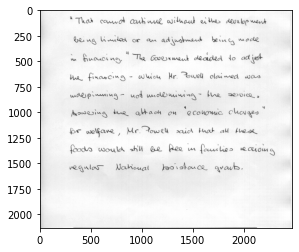

In [ ]:
lst = glob('/content/IAM/forms/*')
plt.imshow(cv2.imread(lst[0], 0)[690:-730, 0:-1], cmap='gray')

In [ ]:
current_fid = lst[0].split('/')[-1].split('.')[0]
print(current_fid, fid_to_wid[current_fid])

a01-132x 000


In [ ]:
def init_fid_to_wid_dict():
    fid_to_wid = dict()
    with open('/content/IAM/ascii/forms.txt') as forms:
        lines = forms.readlines()
        for line in lines:
            if line[0] == '#':
              continue
            splitted = line.split(' ')
            fid = splitted[0]
            wid = splitted[1]
            fid_to_wid[fid] = wid
    return fid_to_wid

In [ ]:
def create_copped_forms(path, forms_path):
    if not os.path.exists(path):
        os.makedirs(path)
    form_paths = glob(forms_path + '/*')

    fid_to_wid = init_fid_to_wid_dict()
    for p in tqdm(form_paths):
        form = cv2.imread(p, 0)
        form = form[690:-730, 0:-1]
        fid = p.split('/')[-1].split('.')[0]
        wid = fid_to_wid[fid]
        cv2.imwrite(path + '/' + fid + '-' + wid + '.png', form)




create_copped_forms('/content/cropped_forms', '/content/IAM/forms')
!zip -r 'cropped_forms.zip' 'cropped_forms'


In [ ]:
%cp -av '/content/cropped_forms.zip' '/content/drive/MyDrive/Final Project/Datasets/'

Examples of Cropped images from our algorithm

42981
/content/RFDS/fake/fake_train/2-There-df316.png


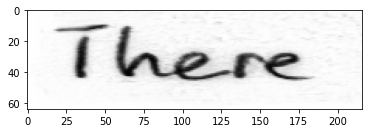

/content/RFDS/fake/fake_train/187-hopes-99b38.png


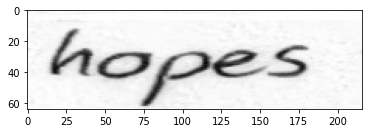

/content/RFDS/fake/fake_train/228-the-2c9f4.png


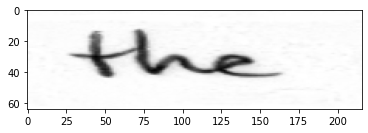

/content/RFDS/fake/fake_train/248-with-2fdac.png


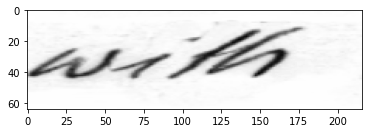

/content/RFDS/fake/fake_train/195-increasing-a072f.png


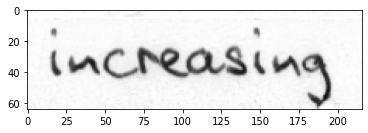

/content/RFDS/fake/fake_train/209-unity-9cfe4.png


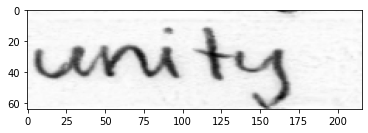

/content/RFDS/fake/fake_train/27-sure-fa5be.png


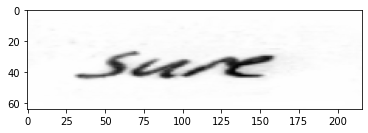

/content/RFDS/fake/fake_train/185-such-35148.png


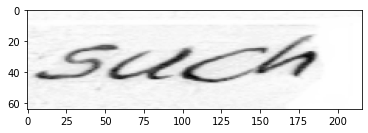

/content/RFDS/fake/fake_train/68-supporters-6fb5a.png


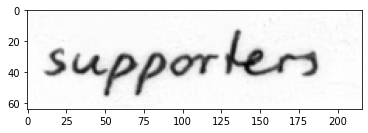

/content/RFDS/fake/fake_train/133-extraordinary-2ff2c.png


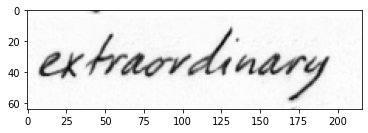

In [ ]:
lst = glob('/content/RFDS/fake/fake_train/*')
print(len(lst))
for i in range(10):

    pic = cv2.imread(lst[i], 0)
    print(lst[i])
    plt.imshow(pic, cmap='gray')
    plt.show()

Distribution of the Real-Fake Dataset - it will later be equalized to be even in numbers

In [ ]:
lst1 = glob('/content/RFDS/fake/fake_train/*')
lst2 = glob('/content/RFDS/fake/fake_test/*')
lst3 = glob('/content/RFDS/fake/fake_val/*')

lst4 = glob('/content/RFDS/real/real_train/*')
lst5 = glob('/content/RFDS/real/real_test/*')
lst6 = glob('/content/RFDS/real/real_val/*')

len1 = len(lst1)
len2 = len(lst2)
len3 = len(lst3)
len4 = len(lst4)
len5 = len(lst5)
len6 = len(lst6)

print('Fake:', len1,
      len2,
      len3)


print('Real:', 
    len4,
    len5,
    len6)   

Fake: 42981 5223 5402
Real: 77309 9695 9769
